# WBCD dataset: Features selection and prediction of cancer diagnosis

On this notebook, we present the Python code to display the figure 2d and the supplementary table 2 of the [article](https://www.researchsquare.com/article/rs-1674043/v1).  

The methodology was inspired by the following article:  

Akay, F. (2009). Support vector machines combined with feature selection for breast cancer diagnosis. *Expert Systems with Applications*, 36(2), p. 3240-3247. doi: 10.1016/j.eswa.2008.01.009

To test the performances of the original and the avatarized datasets, we performed 100 different train/test 70/30 splits with the same stratification.

For each split : 
- We computed F-scores for each feature with the f_score function.
- We trained a SVM model with the 5 best features selected.

## Packages import

In [1]:
# General packages required
import numpy as np
import pandas as pd
import os
import sys
from datetime import date
import time
import math

# Graphical display packages
import matplotlib.pyplot as plt
from matplotlib import use
import seaborn as sns

# Machine Learning tools packages
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Specific functions created

In [2]:
def round_spec(val, dec=2):
    """
    Specific round format for quantitative variable
    Input:
        - val: continuous value
        - dec: number of decimals for the value (2 by default)
    Output:
        - string with the value in the correct format
    """
    return ("{:." + str(dec) + "f}").format(val)

In [3]:
def f_score(X, y, val1=2, val2=4):
    """
    Computation of F-score for each feature.
    Input:
        - X is the feature
        - y is the ouput variable
        - val1 and val2 are the two modalities taken by y

    Output:
        - F-score of the variable X compared to y
    """
    X1 = X[y == val1]
    X2 = X[y == val2]
    mean_X = X.mean()
    mean_X1 = X1.mean()
    mean_X2 = X2.mean()
    n_X1 = len(X1)
    n_X2 = len(X2)
    sum_X1 = ((X1 - mean_X1) ** 2).sum()
    sum_X2 = ((X2 - mean_X2) ** 2).sum()
    return ((mean_X1 - mean_X) ** 2 + (mean_X2 - mean_X) ** 2) / (
        ((1 / (n_X1 - 1)) * sum_X1) + ((1 / (n_X2 - 1)) * sum_X2)
    )

In [4]:
def unique_SVM_model(
    X_train, y_train, X_test, y_test, order, parameters, nb_var, njobs=11
):
    """
    Train a SVM model by founding the best parameters and returns evaluation metrics.
    Input:
        - X_train, y_train, X_test, y_test: train/test datasets to train the SVM model
        - order: vector of features' order resulting from F-scores' calculation
        - parameters: set of parameters to test to have the best parameters in the ML model
        - nb_var: number of features selected for the model

    Output:
        - best_params: parameters used to compute the best model
        - cm: confusion matrix of the best model
        - df_res: dataframe with performance metrics of the best model
        - df_roc: dataframe to draw the ROC curve of the best model
    """
    svc = SVC(probability=True)
    clf = GridSearchCV(svc, parameters, cv=10, n_jobs=njobs)
    clf.fit(X_train[order[0:nb_var]], y_train)
    best_params = clf.best_params_
    cm = pd.crosstab(y_test, clf.predict(X_test[order[0:nb_var]]))
    TP = cm.iloc[0, 0]
    TN = cm.iloc[1, 1]
    FP = cm.iloc[0, 1]
    FN = cm.iloc[1, 0]
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) * 100
    specificity = TN / (TN + FP) * 100
    ppv = TP / (TP + FP) * 100
    npv = TN / (TN + FN) * 100
    auc = metrics.roc_auc_score(
        y_train, clf.predict_proba(X_train[order[0:nb_var]])[:, 1]
    )
    fpr, tpr, thresholds = metrics.roc_curve(
        y_train, clf.predict_proba(X_train[order[0:nb_var]])[:, 1]
    )
    df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})
    df_res = pd.DataFrame(
        [accuracy, sensitivity, specificity, ppv, npv, auc],
        index=["acc", "sens", "spec", "ppv", "npv", "auc"],
    )
    return (best_params, cm, df_res, df_roc)

In [99]:
def get_svm_pipeline_results(df, name): 

    F1_scores = list() # list of F1 score dataframe

    predictions = list() # list of prediction dataframe

    order_features_data = [
        "Bare_Nuclei",
        "Uniformity_of_Cell_Shape",
        "Uniformity_of_Cell_Size",
        "Bland_Chromatin",
        "Clump_Thickness",
        "Marginal_Adhesion",
        "Normal_Nucleoli",
        "Single_Epithelial_Cell_Size",
        "Mitoses",
    ]

    for seed in range(100):
        # Train/test split of dataset
        (
            data_X_train_70,
            data_X_test_30,
            data_y_train_70,
            data_y_test_30,
        ) = train_test_split(
            df.drop("Class", axis=1),
            df.Class,
            train_size=0.7,
            stratify=data.Class,
            random_state=seed,
        )

        # Feature selection 
        F1_score = data_X_train_70.apply(
            lambda col: f_score(col, data_y_train_70, val1=0, val2=1), axis=0
        )
        F1_score = pd.DataFrame(F1_score)
        F1_score["feature"] = F1_score.index
        F1_score["type"] = name
        F1_score = F1_score.reset_index(drop=True)

        F1_scores.append(F1_score)

        # SVM Model
        (
            best_params_data_A_70_5,
            cm_data_A_70_5,
            prediction,
            df_roc_data_A_70_5,
        ) = unique_SVM_model(
            data_X_train_70,
            data_y_train_70,
            data_X_test_30,
            data_y_test_30,
            order_features_data,
            parameters,
            nb_var=5,
            njobs=11,
        )
        prediction = pd.DataFrame(prediction)
        prediction["perf"] = prediction.index
        prediction["type"] = name
        prediction = prediction.reset_index(drop=True)

        predictions.append(prediction)
   
    predictions = pd.concat(predictions)
    F1_scores = pd.concat(F1_scores)

    # Reshape F1_scores
    F1_scores["feature"] = (
        pd.Series(F1_scores["feature"])
        .apply(lambda val: val.replace("_", " "))
        .values
    )
    F1_scores.columns = ["F-score", "feature", "type"]

    return F1_scores, predictions

## Data loading

In [5]:
# Import the color df containing colors combination
colors = pd.read_csv("../color.csv", index_col=0)

In [6]:
file_data = "../datasets/"

In [7]:
# we load original data and avatar data with k = 20
data = pd.read_csv(file_data + "WBCD/breast_cancer_wisconsin.csv")
data = data.drop("Sample_code_number", axis=1)
avatar = pd.read_csv(file_data + "/WBCD/breast_cancer_wisconsin_avatarized_k20.csv")
synthpop = pd.read_csv(file_data + "/WBCD/wbcd_synthpop_base.csv")
ctgan = pd.read_csv(file_data + "/WBCD/wbcd_CTGAN_base_2.csv")

In [8]:
data.Class = data.Class.replace(2, 0)
data.Class = data.Class.replace(4, 1)

avatar.Class = avatar.Class.replace(2, 0)
avatar.Class = avatar.Class.replace(4, 1)

synthpop.Class = synthpop.Class.replace(2, 0)
synthpop.Class = synthpop.Class.replace(4, 1)

ctgan.Class = ctgan.Class.replace(2, 0)
ctgan.Class = ctgan.Class.replace(4, 1)

## Parameters

In [9]:
# Parameters map for the SVM model
map_object = map(lambda val: 2**val, list(range(-15, 3)))
gamma_list = list(map_object)

map_object = map(lambda val: 2**val, list(range(-5, 16)))
C_list = list(map_object)

parameters = {"kernel": ["rbf"], "C": C_list, "gamma": gamma_list}

## Analysis computation 

The following cell is time consuming (more than 80 minutes).
To simplify the access to the paper figures, we saved the results obtained at the end of the following function in a dataframe that you can load after this cell.   
Thus, the execution is not required.
If you still want to compute it, change the variable **compute** from *False* to *True* at the first line of the cell.

### Original - Avatar comparison 

In [136]:
# The computation could be higher than 80 min - data has been saved in a data frame
compute = False
if compute: 
    datasets = [(data, "Original"), (avatar, "Avatar"), (synthpop, "Synthpop"), (ctgan, "CT-GAN") ]

    comparative_f1_scores = []
    comparative_predictions = []
    for df, name in datasets: 
        print("dataset: ", name)
        F1_scores, predictions = get_svm_pipeline_results(df, name)
        comparative_f1_scores.append(F1_scores)
        comparative_predictions.append(predictions)

    comparative_f1_scores = pd.concat(comparative_f1_scores, ignore_index=True)
    comparative_predictions = pd.concat(comparative_predictions, ignore_index=True)

    comparative_f1_scores.to_csv("../datasets/results_df/comparative_f1_scores.csv", index=False)
    comparative_predictions.to_csv("../datasets/results_df/comparative_predictions.csv", index=False)


In [137]:
comparative_f1_scores = pd.read_csv("../datasets/results_df/comparative_f1_scores.csv")
comparative_predictions = pd.read_csv("../datasets/results_df/comparative_predictions.csv")


In [184]:
comparative_f1_scores_avatar = comparative_f1_scores[(comparative_f1_scores['type'] == 'Original') | (comparative_f1_scores['type'] == 'Avatar')]
comparative_f1_scores_synthpop = comparative_f1_scores[(comparative_f1_scores['type'] == 'Original') | (comparative_f1_scores['type'] == 'Synthpop')]
comparative_f1_scores_ctgan = comparative_f1_scores[(comparative_f1_scores['type'] == 'Original') | (comparative_f1_scores['type'] == 'CT-GAN')]


In [185]:
comparative_predictions_avatars = comparative_predictions[(comparative_predictions['type'] == 'Original') | (comparative_predictions['type'] == 'Avatar')]
comparative_predictions_synthpop = comparative_predictions[(comparative_predictions['type'] == 'Original') | (comparative_predictions['type'] == 'Synthpop')]
comparative_predictions_ctgan = comparative_predictions[(comparative_predictions['type'] == 'Original') | (comparative_predictions['type'] == 'CT-GAN')]




In [186]:
comparative_f1_scores_avatar

,F-score,feature,type
0,0.992456,Clump Thickness,Original
1,2.078408,Uniformity of Cell Size,Original
2,1.916183,Uniformity of Cell Shape,Original
3,0.840571,Marginal Adhesion,Original
4,0.836190,Single Epithelial Cell Size,Original
...,...,...,...
1795,1.059681,Single Epithelial Cell Size,Avatar
1796,2.245389,Bare Nuclei,Avatar
1797,1.541269,Bland Chromatin,Avatar
1798,0.996427,Normal Nucleoli,Avatar


In [187]:
def include_prediction_in_f1score(comparative_predictions_synthetic, comparative_f1_scores_synthetic, synthetic):
    auc_original = comparative_predictions_synthetic.loc[
        (comparative_predictions_synthetic.perf == "auc") & (comparative_predictions_synthetic.type == "Original"), "0"
    ]
    auc_synthetic = comparative_predictions_synthetic.loc[
        (comparative_predictions_synthetic.perf == "auc") & (comparative_predictions_synthetic.type == synthetic), "0"
    ]

    comparative_f1_scores_synthetic.type = comparative_f1_scores_synthetic.type.replace(
        "Original",
        "Original (AUC = " + str(round(np.mean(auc_original) * 100, 2)) + ")",
    )  # \u00B1 " + str(round(np.std(auc_original), 3)) + "
    comparative_f1_scores_synthetic.type = comparative_f1_scores_synthetic.type.replace(
        synthetic, "Avatar (AUC = " + str(round(np.mean(auc_synthetic) * 100, 2)) + ")"
    )  # \u00B1 " + str(round(np.std(auc_avatar), 3)) + ")")

    return comparative_f1_scores_synthetic

In [188]:
comparative_f1_scores_avatar = include_prediction_in_f1score(comparative_predictions_avatars, comparative_f1_scores_avatar, synthetic="Avatar")
comparative_f1_scores_synthpop = include_prediction_in_f1score(comparative_predictions_synthpop, comparative_f1_scores_synthpop, synthetic="Synthpop")
comparative_f1_scores_ctgan = include_prediction_in_f1score(comparative_predictions_ctgan, comparative_f1_scores_ctgan, synthetic="CT-GAN")

/var/folders/kc/s79hq4hx3rlfjs7y7_0kn51r0000gn/T/ipykernel_41995/1007617656.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparative_f1_scores_synthetic.type = comparative_f1_scores_synthetic.type.replace(
/var/folders/kc/s79hq4hx3rlfjs7y7_0kn51r0000gn/T/ipykernel_41995/1007617656.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparative_f1_scores_synthetic.type = comparative_f1_scores_synthetic.type.replace(



## Graphs F-scores

We performed the F-score figure, with confidence intervals of the mean (95%).

In [194]:
def plot_f1_score(df, save=False, name="synthetic"):
    # Figure context
    paper_rc = {"lines.linewidth": 2, "lines.markersize": 10}
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.9, rc=paper_rc)
    with plt.style.context("seaborn-whitegrid"):
        plt.rcParams["axes.edgecolor"] = "0.15"
        plt.rcParams["axes.linewidth"] = 1.25
        plt.rcParams["font.family"] = "sans-serif"
        plt.rcParams["font.sans-serif"] = "Helvetica"

        fig = plt.figure(figsize=(10, 7))  # create a figure object
        ax1 = fig.add_subplot()

    # add barplot with confidence intervals.
    ax = sns.barplot(
        x="F-score",
        y="feature",
        hue="type",
        data=df,
        order=[
            "Bare Nuclei",
            "Uniformity of Cell Shape",
            "Uniformity of Cell Size",
            "Bland Chromatin",
            "Clump Thickness",
            "Normal Nucleoli",
            "Marginal Adhesion",
            "Single Epithelial Cell Size",
            "Mitoses",
        ],
        ci=95,
        linewidth=1.2,
        edgecolor=".2",
        # color by avatar and original colors
        palette=(colors.loc["original", "color"], colors.loc[name, "color"]),
    )

    ax.set(ylabel="")
    plt.legend(title="", loc="lower right")
    if save:
        plt.savefig("../figures/WBCD_f-score_70_30_"+name+".svg", format = "svg", bbox_inches = "tight")
    plt.show()

In [195]:
comparative_f1_scores_avatar

,F-score,feature,type
0,0.992456,Clump Thickness,Original (AUC = 99.46)
1,2.078408,Uniformity of Cell Size,Original (AUC = 99.46)
2,1.916183,Uniformity of Cell Shape,Original (AUC = 99.46)
3,0.840571,Marginal Adhesion,Original (AUC = 99.46)
4,0.836190,Single Epithelial Cell Size,Original (AUC = 99.46)
...,...,...,...
1795,1.059681,Single Epithelial Cell Size,Avatar (AUC = 99.84)
1796,2.245389,Bare Nuclei,Avatar (AUC = 99.84)
1797,1.541269,Bland Chromatin,Avatar (AUC = 99.84)
1798,0.996427,Normal Nucleoli,Avatar (AUC = 99.84)


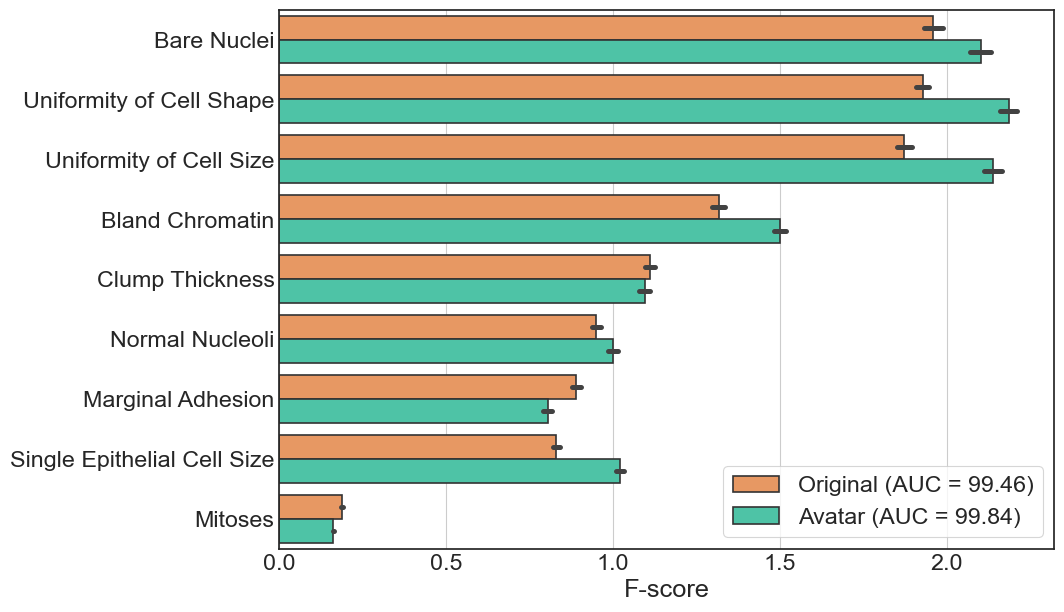

In [197]:
plot_f1_score(comparative_f1_scores_avatar, save=True, name="avatar")

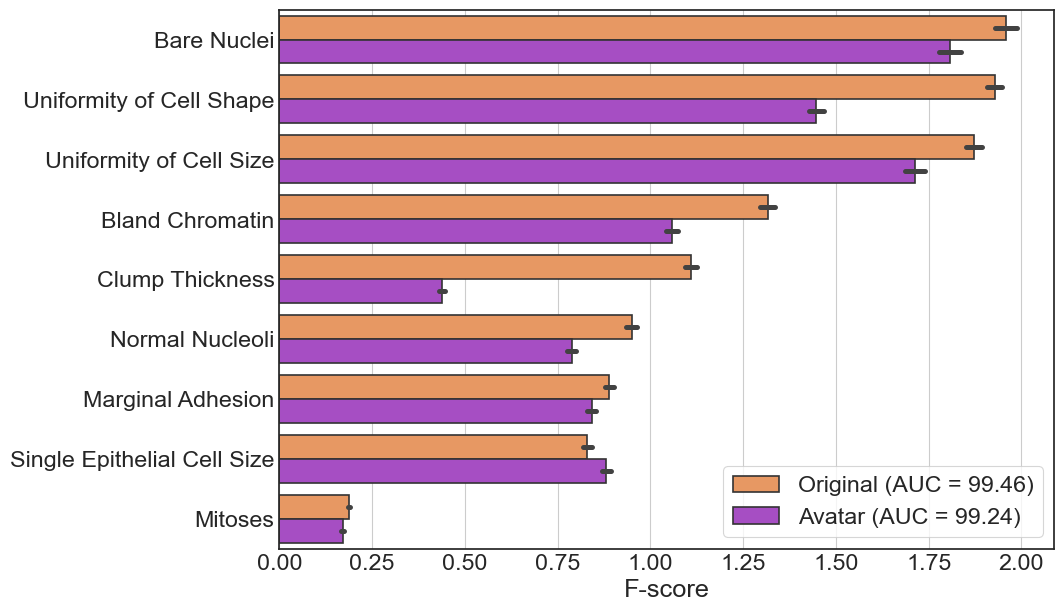

In [198]:
plot_f1_score(comparative_f1_scores_synthpop, save=True, name="synthpop")

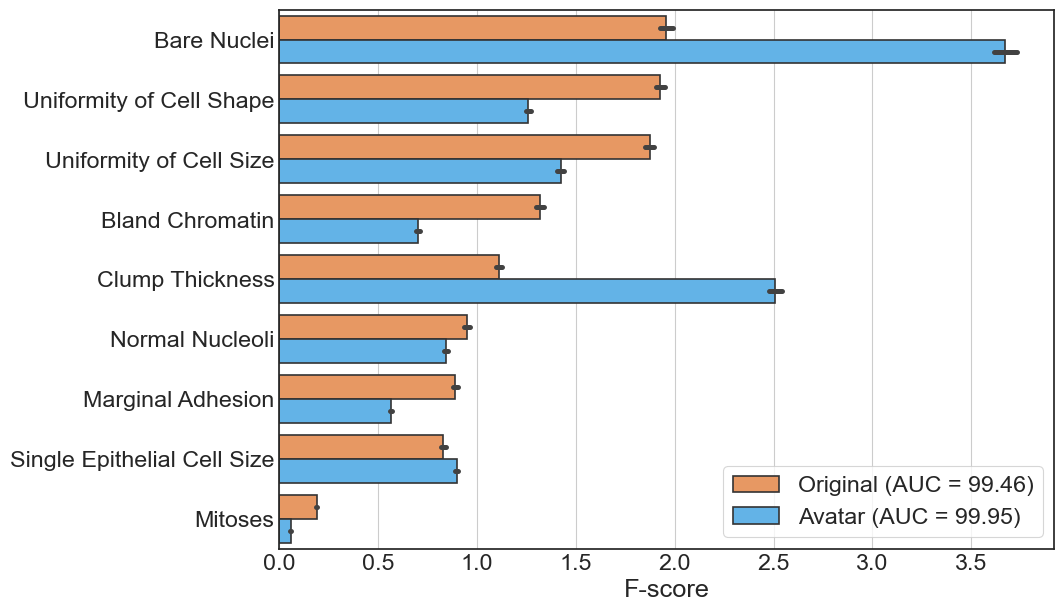

In [199]:
plot_f1_score(comparative_f1_scores_ctgan, save=True, name="ctgan")


## Supplemental table

We computed prediction performances for each split for avatar and original data. 
Results are presented in table.

In [120]:
def get_prediction_metrics(df):
    # multiple accuracy and auc to get them in percentage
    df.loc[df["perf"] == "acc", "0"] *= 100
    df.loc[df["perf"] == "auc", "0"] *= 100

    # perform stats ok classification metrics
    prediction_metrics = df.groupby(["perf", "type"]).agg({"0": ["mean", "std"]})
    prediction_metrics = prediction_metrics.reset_index()
    prediction_metrics.columns = ["Metric", "type", "mean", "std"]
    prediction_metrics["values"] = (
        prediction_metrics["mean"].apply(round_spec, 3)
        + " (\u00B1 "
        + prediction_metrics["std"].apply(round_spec, 3)
        + ")"
    )
    prediction_metrics = prediction_metrics.pivot(index="Metric", columns="type", values="values")
    prediction_metrics.columns = prediction_metrics.columns.values
    prediction_metrics = prediction_metrics.reset_index(col_level=0)
    prediction_metrics["Metric"] = ["Accuracy", "AUC", "NPV", "PPV", "Sensitivy", "Specificity"]
    
    return(prediction_metrics)


In [122]:
get_prediction_metrics(comparative_predictions_avatars)

,Metric,Avatar,Original
0,Accuracy,97.04 (± 0.99),96.58 (± 1.25)
1,AUC,99.84 (± 0.12),99.46 (± 0.25)
2,NPV,96.07 (± 2.77),96.08 (± 2.88)
3,PPV,97.60 (± 1.62),96.85 (± 1.35)
4,Sensitivy,97.87 (± 1.49),97.88 (± 1.51)
5,Specificity,95.69 (± 2.83),94.35 (± 2.28)


In [123]:
get_prediction_metrics(comparative_predictions_synthpop)

,Metric,Original,Synthpop
0,Accuracy,96.58 (± 1.25),95.75 (± 1.29)
1,AUC,99.46 (± 0.25),99.24 (± 0.58)
2,NPV,96.08 (± 2.88),95.34 (± 2.59)
3,PPV,96.85 (± 1.35),95.99 (± 1.83)
4,Sensitivy,97.88 (± 1.51),97.28 (± 1.48)
5,Specificity,94.35 (± 2.28),93.27 (± 2.96)


In [124]:
get_prediction_metrics(comparative_predictions_ctgan)

,Metric,CT-GAN,Original
0,Accuracy,99.21 (± 0.46),96.58 (± 1.25)
1,AUC,99.95 (± 0.04),99.46 (± 0.25)
2,NPV,99.09 (± 0.71),96.08 (± 2.88)
3,PPV,99.36 (± 0.78),96.85 (± 1.35)
4,Sensitivy,98.86 (± 0.89),97.88 (± 1.51)
5,Specificity,99.49 (± 0.63),94.35 (± 2.28)


In [19]:
# res_mean.to_csv('../datasets/results_df/supplemental_table_WBCD_synthpop.csv', index = False, header=True)